In [1]:
%run _startup.ipynb

In [2]:
MIN_DATE = '1999-12-01'

In [3]:
plt.style.use('bmh')

### 1. Target analysis

In [4]:
# merge target with meetings
df_meetings = pd.read_pickle('data/df_meetings.pkl')
df_target = pd.read_pickle('data/df_target.pkl')

df = df_meetings.merge(df_target, how = 'left')
df = df[df.dt_month > MIN_DATE]
df['dt1'] = df['dt_month']
del df['dt_month']
del df['meetings']
df = df.set_index('dt1')

# fill nulls
df['DFEDTAR'] = df['DFEDTAR'].ffill()
df['DFEDTAR_diff'] = df['DFEDTAR_diff'].fillna(0)
df['cnt_change'] = df['cnt_change'].fillna(0).astype(int)

# map the target label
def map_target1(x):
    if x <= -0.5:
        return 0
    if x <= -0.25:
        return 1
    if x == 0:
        return 2
    if x <= 0.25:
        return 3
    return 4
def map_target2(x):
    if x < 0:
        return 0
    if x == 0:
        return 1
    return 2

list_class = ['0)-0.50%', '1)-0.25%', '2)0%', '3)+0.25%', '4)+0.50%']
df['DFEDTAR_diff_lbl'] = df['DFEDTAR_diff'].map(map_target1)
df['DFEDTAR_diff_cat'] = df['DFEDTAR_diff_lbl'].map({k:v for k,v in enumerate(list_class)})

print(df.shape)
df[:5]

(218, 6)


,cnt_meetings,DFEDTAR,DFEDTAR_diff,cnt_change,DFEDTAR_diff_lbl,DFEDTAR_diff_cat
dt1,,,,,,
2000-02-01,1,5.75,0.25,1,3,3)+0.25%
2000-03-01,1,6.00,0.25,1,3,3)+0.25%
2000-05-01,1,6.50,0.50,1,4,4)+0.50%
2000-06-01,1,6.50,0.00,0,2,2)0%
2000-08-01,1,6.50,0.00,0,2,2)0%


In [5]:
# yearly stat
df['dt_year'] = df.reset_index().dt1.dt.year.values
def get_plus(x):
    return x[x > 0].sum()
def get_minus(x):
    return x[x < 0].sum()
    
x = df.groupby('dt_year').agg({
    'cnt_meetings': sum,
    'cnt_change': sum,
    'DFEDTAR_diff': [get_minus,get_plus],
})
x.columns = ['cnt_meetings','cnt_change','decrease','increase']

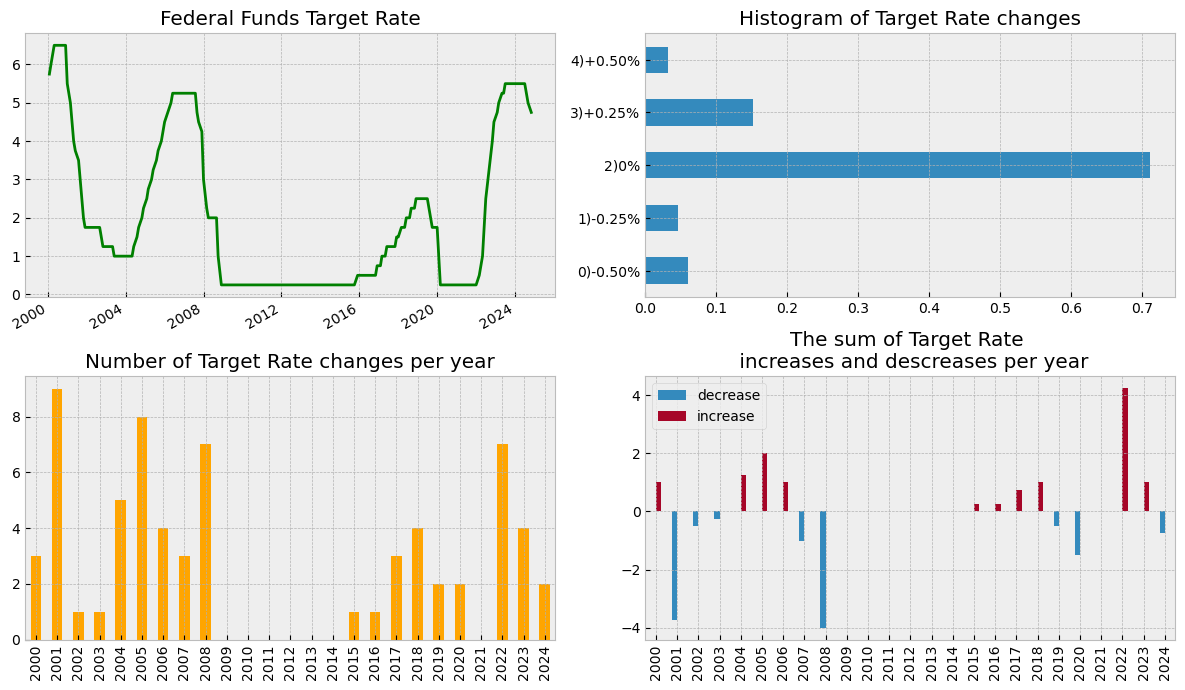

In [6]:
# plots
_, ax = plt.subplots(2,2, figsize = (12,7))

_ = df['DFEDTAR'].plot(ax = ax[0][0], color = 'green', xlabel = '', title = 'Federal Funds Target Rate')
_ = df['DFEDTAR_diff_cat'].value_counts(normalize = True).sort_index().plot(ax = ax[0][1], kind = 'barh', ylabel = '', title = 'Histogram of Target Rate changes')

_ = x['cnt_change'].plot(ax = ax[1][0], kind = 'bar', xlabel = '', color = 'orange', title = 'Number of Target Rate changes per year')

feats = ['decrease','increase']
_ = x[feats].plot(ax = ax[1][1], kind = 'bar', xlabel = '', title = 'The sum of Target Rate \n increases and descreases per year')

plt.tight_layout()

### 2. Features analysis

In [7]:
dict_feats = {
 'Economic Activity': 'GDP GDPC1 EXPGS PNFI INDPRO CFNAI',
 'Financial Conditions': 'TOTBKCR DPSACBW027SBOG STLFSI4 NFCI',
 'Inflation': 'CPILFESL CPIAUCSL PCE PCEPI PCEPILFE MICH',
 'Labor Market Conditions': 'PAYEMS UNRATE EMRATIO',
 'Monetary Policy Actions': 'WSECOUT'
}

dict_reg = {
 'Lag monthly': 'INDPRO CFNAI PCE PCEPI PCEPILFE MICH',
 'Monthly': 'CPILFESL CPIAUCSL PAYEMS UNRATE EMRATIO',
 'Quarterly': 'GDP GDPC1 EXPGS PNFI',
 'Weekly': 'TOTBKCR DPSACBW027SBOG STLFSI4 NFCI WSECOUT'
}

dict_post = {
 'diff12': 'UNRATE EMRATIO',
 'pct12': 'GDP GDPC1 EXPGS PNFI TOTBKCR DPSACBW027SBOG CPILFESL CPIAUCSL PCE PCEPI PCEPILFE PAYEMS WSECOUT'
}

In [8]:
# set colors for groups
list_colors = list()
dict_colors = {
 'Economic Activity': 'green',
 'Financial Conditions': 'darkblue',
 'Inflation': 'darkred',
 'Labor Market Conditions': 'purple',
 'Monetary Policy Actions': 'orange'
}
for k,v in dict_feats.items():
    list_colors += [dict_colors[k]]*len(v.split(' '))

In [9]:
df_feats = pd.read_pickle('data/df_feats.pkl')
df_feats = df_feats[df_feats.dt1 > MIN_DATE].set_index('dt1')

print(df_feats.shape)
df_feats[:3]

(299, 20)


,GDP,GDPC1,EXPGS,PNFI,INDPRO,CFNAI,TOTBKCR,DPSACBW027SBOG,STLFSI4,NFCI,CPILFESL,CPIAUCSL,PCE,PCEPI,PCEPILFE,MICH,PAYEMS,UNRATE,EMRATIO,WSECOUT
dt1,,,,,,,,,,,,,,,,,,,,
2000-01-01,"9,900.17","13,827.98","1,030.97","1,395.05",91.48,0.59,"4,536.15","3,479.46",-0.02,-0.19,179.30,169.30,"6,541.00",72.76,74.13,3.00,"131,009.00",4.00,64.60,489.67
2000-02-01,"9,900.17","13,827.98","1,030.97","1,395.05",91.41,0.18,"4,555.69","3,494.00",0.09,-0.19,179.40,170.00,"6,542.90",72.96,74.31,3.00,"131,120.00",4.10,64.60,501.91
2000-03-01,"9,900.17","13,827.98","1,030.97","1,395.05",91.72,-0.22,"4,610.16","3,522.33",0.01,-0.12,180.00,171.00,"6,625.30",73.19,74.42,2.90,"131,604.00",4.00,64.60,501.69


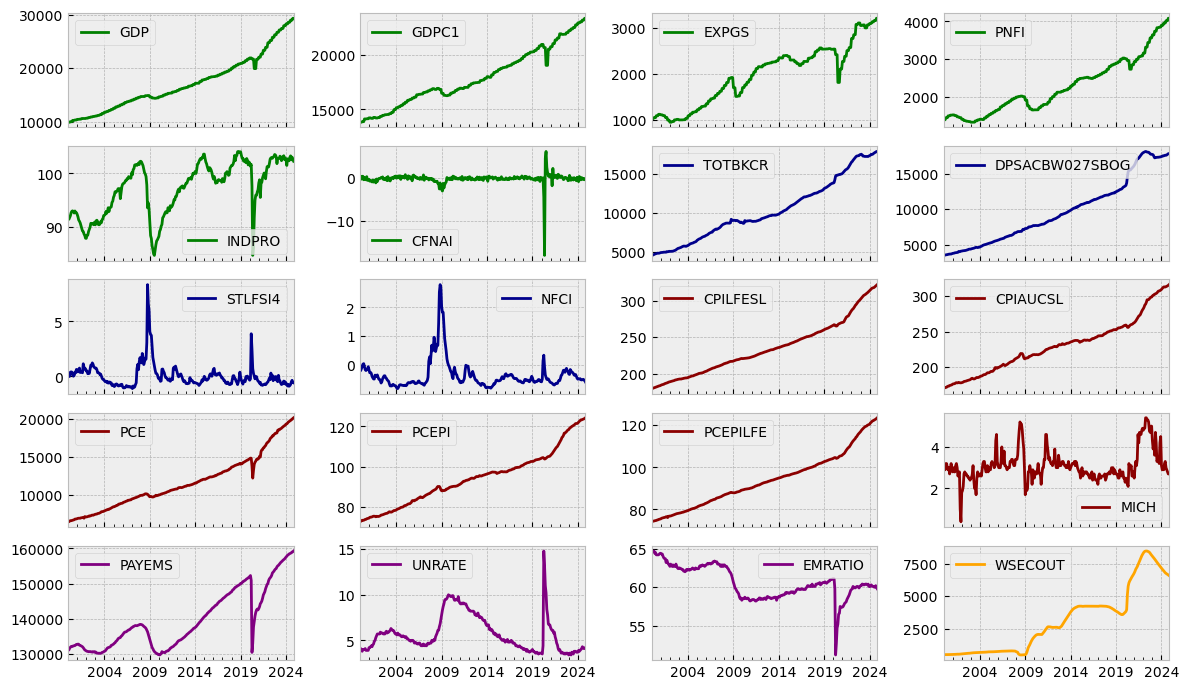

In [10]:
_ = df_feats.plot(subplots = True, layout = (5,4), figsize = (12,7), xlabel = '', color = list_colors)
plt.tight_layout()

### 3. Features impact

In [11]:
# Preprocess features
df_feats = pd.read_pickle('data/df_feats.pkl')

feats = dict_post['pct12'].split(' ')
for feat in feats:
    df_feats[feat] = df_feats[feat].pct_change(12)
    df_feats = df_feats.rename(columns = {feat: feat+'_pct12'})

feats = dict_post['diff12'].split(' ')
for feat in feats:
    df_feats[feat] = df_feats[feat].diff(12)
    df_feats = df_feats.rename(columns = {feat: feat+'_diff12'})

df_feats = df_feats[df_feats.dt1 > MIN_DATE].set_index('dt1')

print(df_feats.shape)
df_feats[-3:]

(299, 20)


,GDP_pct12,GDPC1_pct12,EXPGS_pct12,PNFI_pct12,INDPRO,CFNAI,TOTBKCR_pct12,DPSACBW027SBOG_pct12,STLFSI4,NFCI,CPILFESL_pct12,CPIAUCSL_pct12,PCE_pct12,PCEPI_pct12,PCEPILFE_pct12,MICH,PAYEMS_pct12,UNRATE_diff12,EMRATIO_diff12,WSECOUT_pct12
dt1,,,,,,,,,,,,,,,,,,,,
2024-09-01,0.06,0.03,0.05,0.05,103.04,-0.04,0.03,0.02,-0.35,-0.52,0.03,0.02,0.05,0.02,0.03,2.80,0.02,0.30,-0.20,-0.10
2024-10-01,0.05,0.03,0.05,0.06,102.55,-0.27,0.04,0.03,-0.54,-0.52,0.03,0.03,0.05,0.02,0.03,2.70,0.01,0.30,-0.30,-0.10
2024-11-01,0.05,0.03,0.05,0.06,102.28,-0.40,0.04,0.03,-0.58,-0.58,0.03,0.03,0.05,0.02,0.03,2.70,0.01,0.50,-0.60,-0.10


In [12]:
# Add row for new predictions
df1 = pd.DataFrame([[0]*df.shape[1]], columns = df.columns, index = df.index[-1:])

In [13]:
# Shift targets 1 month back (for merging with feats)
df.index = df.index.map(lambda x: x - relativedelta(months = 1))

df = pd.concat([df, df1])

print(df.shape)
df[-3:]

(219, 7)


,cnt_meetings,DFEDTAR,DFEDTAR_diff,cnt_change,DFEDTAR_diff_lbl,DFEDTAR_diff_cat,dt_year
dt1,,,,,,,
2024-08-01,1,5.00,-0.50,1,0,0)-0.50%,2024
2024-10-01,1,4.75,-0.25,1,1,1)-0.25%,2024
2024-11-01,0,0.00,0.00,0,0,0,0


In [14]:
# Merge targets and feats
df = df.join(df_feats)
print(df.shape)

(219, 27)


In [15]:
# Map the color of the target
colors = ['darkred','red','orange','lightblue','blue','darkblue']
def map_color(x):
    if x == 0:
        return 'white'
    if x >= 0.6:
        return colors[0]
    if x >= 0.5:
        return colors[1]
    if x >= 0.25:
        return colors[2]
    if x >= -0.25:
        return colors[3]
    if x >= -0.5:
        return colors[4]
    return colors[5]
    
df['color'] = df.DFEDTAR_diff.map(map_color)
print(df.shape)
df[:2]

(219, 28)


,cnt_meetings,DFEDTAR,DFEDTAR_diff,cnt_change,DFEDTAR_diff_lbl,DFEDTAR_diff_cat,dt_year,GDP_pct12,GDPC1_pct12,EXPGS_pct12,PNFI_pct12,INDPRO,CFNAI,TOTBKCR_pct12,DPSACBW027SBOG_pct12,STLFSI4,NFCI,CPILFESL_pct12,CPIAUCSL_pct12,PCE_pct12,PCEPI_pct12,PCEPILFE_pct12,MICH,PAYEMS_pct12,UNRATE_diff12,EMRATIO_diff12,WSECOUT_pct12,color
dt1,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-01,1,5.75,0.25,1,3,3)+0.25%,2000,0.07,0.05,0.07,0.08,91.48,0.59,0.07,0.05,-0.02,-0.19,0.02,0.03,0.08,0.02,0.01,3.00,0.03,-0.30,0.20,0.08,orange
2000-02-01,1,6.00,0.25,1,3,3)+0.25%,2000,0.07,0.05,0.07,0.08,91.41,0.18,0.07,0.05,0.09,-0.19,0.02,0.03,0.08,0.02,0.02,3.00,0.02,-0.30,0.40,0.10,orange


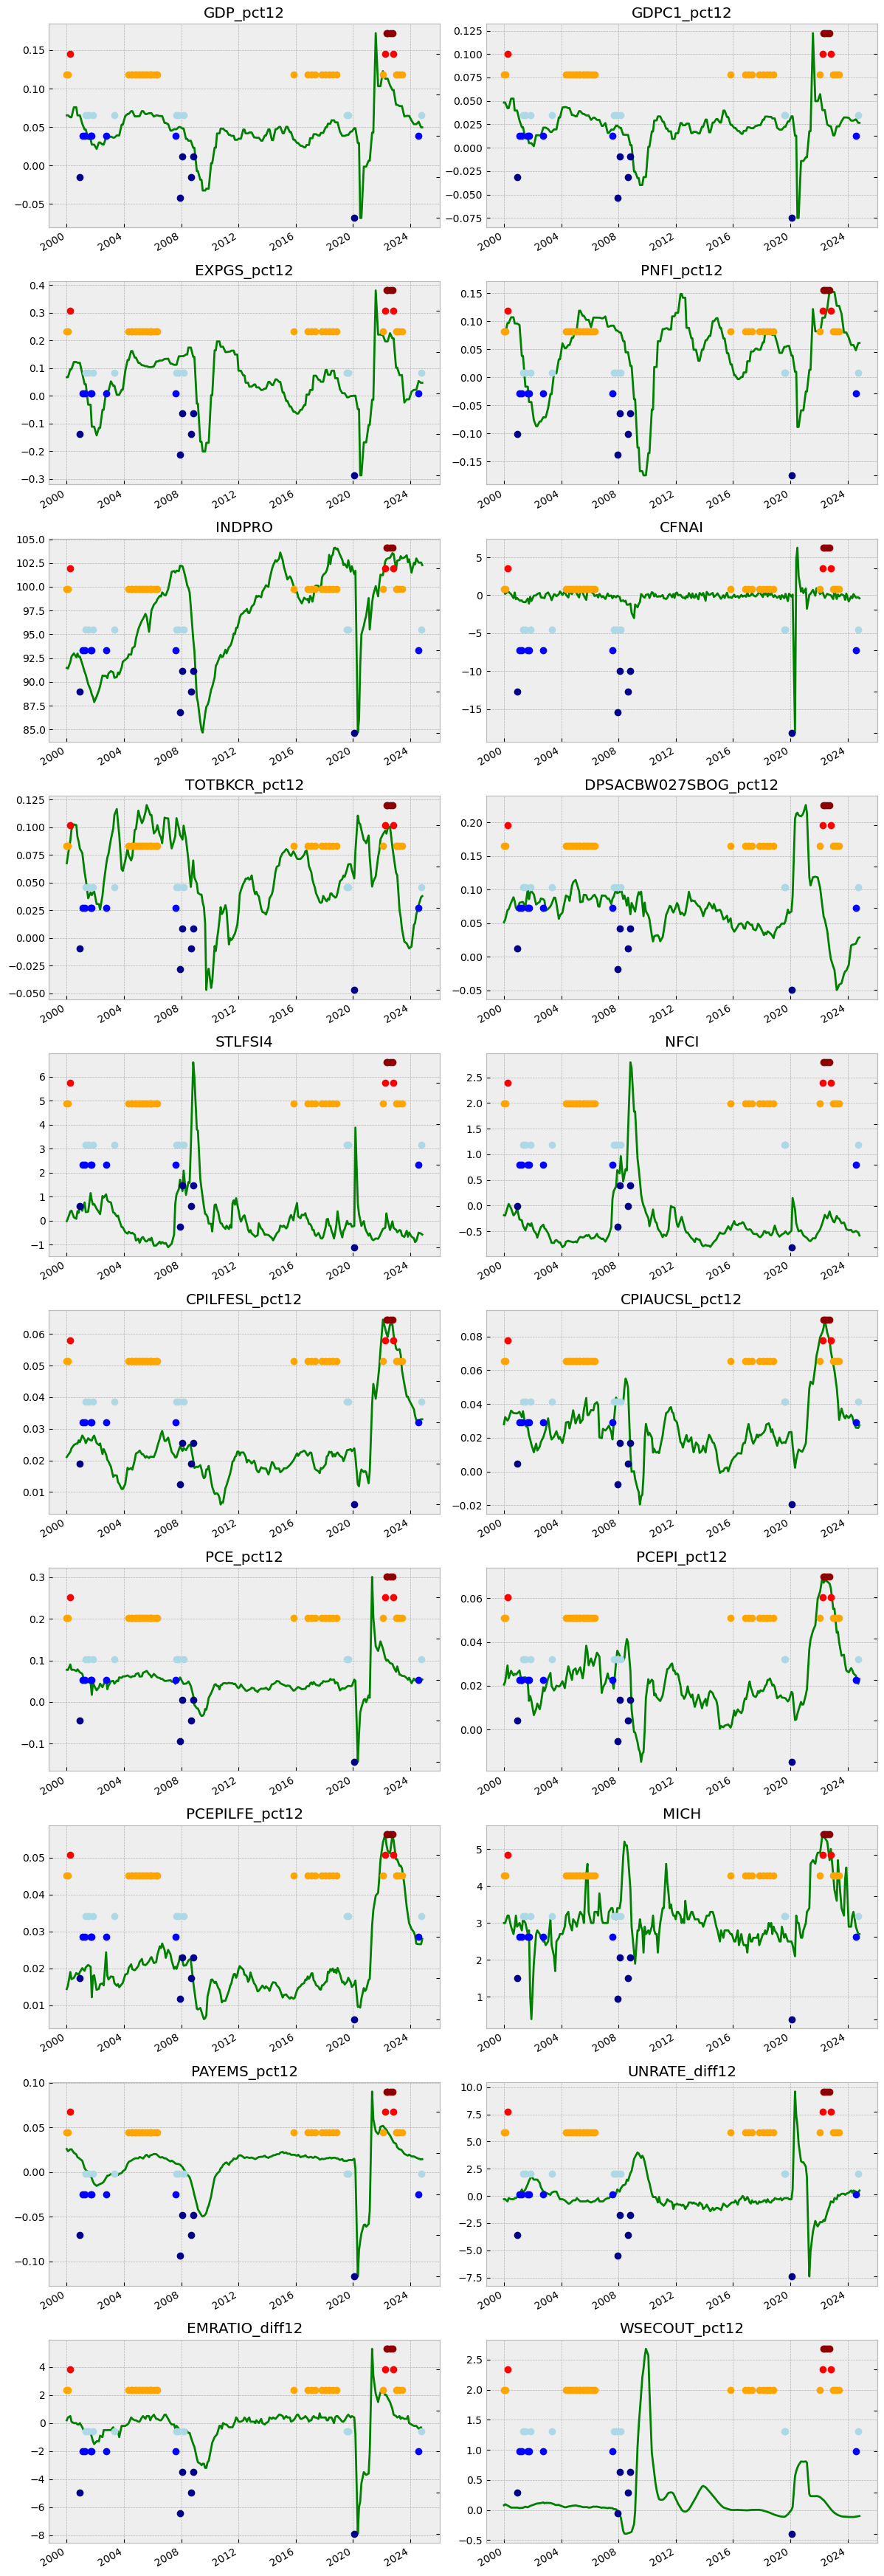

In [16]:
# plotting
feats = list(df_feats.columns)

_, ax = plt.subplots(10,2, figsize = (12,35))
for i,feat in enumerate(feats):
    j = i//2
    i = i%2
    df[feat].plot(ax = ax[j][i], title = feat, style = '-', color = 'green')
    # _ = ax[j][i].hlines(y = 0, xmin = MIN_DATE, xmax = '2025-12-01', color = 'black', linestyle = '--')
    
    feat1 = 'DFEDTAR_diff'
    df1 = df[[feat1,'color']].replace(0, np.nan)
    for col in df1['color'].unique():
        filt = df1['color'] == col
        _ = df1[filt][feat1].plot(ax = ax[j][i], secondary_y = True, xlabel = '', style = 'o', color = col)
        _.set_yticklabels('')
    
plt.tight_layout()

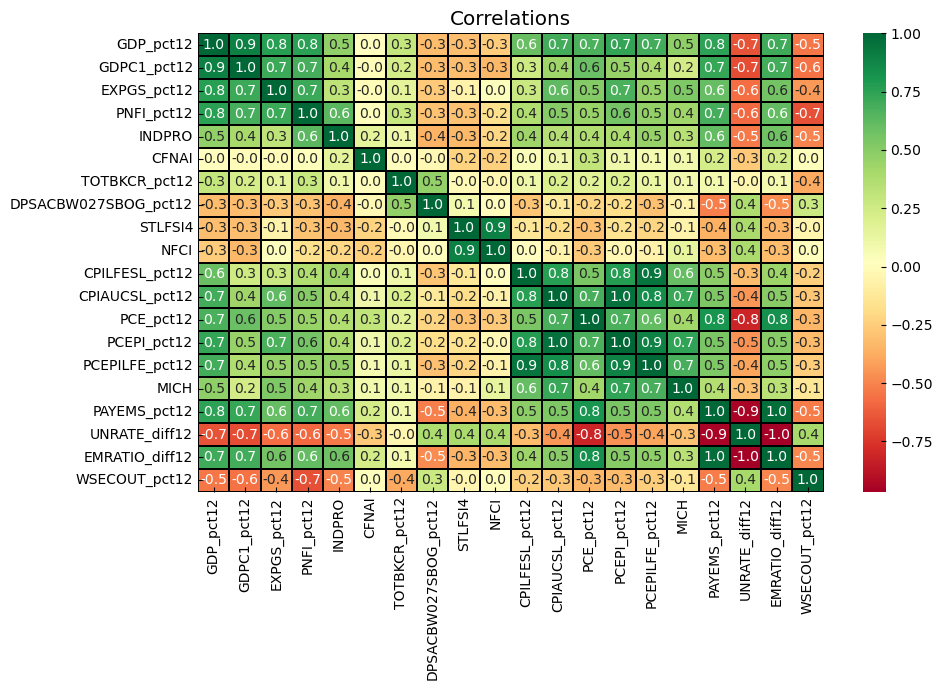

In [17]:
# corr matrix
df_corr = df[feats].corr()
_, ax = plt.subplots(figsize = (10,7))
_ = sns.heatmap(df_corr, ax = ax, cmap = 'RdYlGn', annot = True, fmt = ',.1f', annot_kws={"size": 10}, 
                linewidth = 0.01, linecolor = 'black')
_ = ax.set_title('Correlations')
plt.gca().grid(False)
plt.tight_layout()

In [18]:
# export dataset for training
feats_trg = ['DFEDTAR_diff','DFEDTAR_diff_lbl']
df[feats_trg + feats].to_pickle('data/df_main.pkl')

In [19]:
list(df.columns)

['cnt_meetings',
 'DFEDTAR',
 'DFEDTAR_diff',
 'cnt_change',
 'DFEDTAR_diff_lbl',
 'DFEDTAR_diff_cat',
 'dt_year',
 'GDP_pct12',
 'GDPC1_pct12',
 'EXPGS_pct12',
 'PNFI_pct12',
 'INDPRO',
 'CFNAI',
 'TOTBKCR_pct12',
 'DPSACBW027SBOG_pct12',
 'STLFSI4',
 'NFCI',
 'CPILFESL_pct12',
 'CPIAUCSL_pct12',
 'PCE_pct12',
 'PCEPI_pct12',
 'PCEPILFE_pct12',
 'MICH',
 'PAYEMS_pct12',
 'UNRATE_diff12',
 'EMRATIO_diff12',
 'WSECOUT_pct12',
 'color']